# Contributions

AY24/25 Semester 2 SC3000 Lab Assignment 1 Group SCS2 Team:
1.   PHUN WEI CHENG RUSSELL (U2120850J) - Development & Implementation of Q-Learning Reinforcement Learning Agent
2.   MOHAMED NUR HAZIM BIN MOI ()
3.   SUM YUAN SEN ()

All team members have made equal contributions to the project.








# Importing of Dependencies


In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1



The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.


In [2]:
import numpy as np
import gym
import pickle
import matplotlib.pyplot as plt

from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# Loading of Cartpole Environment

Using the gym library, we create the cartpole environment. Afterwards, we verify the action and observation space to get an overview of the environment.   

### Action Space
The action is an ndarray with shape (1,) which can take values {0, 1}, which signify pushing the cart left or right respectively.The velocity that is reduced or increased by the applied force is not fixed - it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.   

### Observation Space
The observation is an ndarray with shape (4,) with the values corresponding to the following positions and velocities:

In [3]:
env = gym.make('CartPole-v1')
print("Shape of action space: ",env.action_space)
print("Shape of observation space: ", env.observation_space.shape[0])

Shape of action space:  Discrete(2)
Shape of observation space:  4


---

# Task 1: Development of an RL agent



## 1.1 Development of Q-learning Agent

The RL agent we implement is the Q-learning agent, an example of an off-policy reinforcement learning that finds the bset course of action given the current state of the agent.

#### Q-Learning Equation

$$ Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1}+ \gamma \underset{a}{max} Q_{old}(S_{t+1}, a) - Q_{old}(S_{t}, A_{t})) $$

Our implementation of the Q-Agent is with the formulas given in our lecture for updating of the Q-table.   

#### Exploration Rate   

The exploration rate introduces epsilon and epsilon decay. This encourages the agent to explore during the beginning of its training. As the agent becomes more experienced, the exploration rate decreases, reducing the randomness of actions.   


In [4]:
class QLearningAgent:
    """Q-Learning agent

    Attributes:
        env: OpenAI Gym environment
        q: Q table
        pos_space: position space
        vel_space: velocity space
        ang_space: pole angle space
        ang_vel_space: pole angular velocity space
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration rate
        epsilon_decay: exploration rate decay
    """
    def __init__(self, env):
        # Environment
        self.env = env

        # Divide position, velocity, pole angle, and pole angular velocity into segments
        self.pos_space = np.linspace(-2.4, 2.4, 7) 
        self.vel_space = np.linspace(-4.0, 4.0, 7) 
        self.ang_space = np.linspace(-.2095, .2095, 7)
        self.ang_vel_space = np.linspace(-4.0, 4.0, 7)

        # Initialize Q table
        self.q = np.zeros((len(self.pos_space)+1, len(self.vel_space)+1, len(self.ang_space)+1, len(self.ang_vel_space)+1, self.env.action_space.n)) 

        # Hyperparameters
        self.alpha = 0.1 # learning rate
        self.gamma = 0.95 # discount factor
        self.epsilon = 0.1 # exploration rate
        self.epsilon_decay = 0.00001 # exploration rate decay

        self.rng = np.random.default_rng() # Random number generator

    """Run one episode of the environment
    
    Args:
        is_training: boolean to indicate if the agent is training or testing
    """
    def run_one_episode(self, is_training=True):
        # Get initial state
        state = self.env.reset()[0]

        # Discretize state
        state_p = np.digitize(state[0], self.pos_space) 
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)

        # Initialize variables
        terminated = False
        rewards = 0

        # Loop through one episode
        while(not terminated):
            # Choose action based on epsilon-greedy policy
            if is_training and np.random.uniform() < self.epsilon:
                action = self.env.action_space.sample()
            else:
                action = np.argmax(self.q[state_p, state_v, state_a, state_av, :]) # Choose action based on Q table
         
              
            # Take action, get new state and reward
            new_state, reward, terminated, _, _ = self.env.step(action)
            new_state_p = np.digitize(new_state[0], self.pos_space)
            new_state_v = np.digitize(new_state[1], self.vel_space)
            new_state_a = np.digitize(new_state[2], self.ang_space)
            new_state_av = np.digitize(new_state[3], self.ang_vel_space)
            # Update Q table based on Bellman equation
            if is_training:
                self.q[state_p, state_v, state_a, state_av, action] = self.q[state_p, state_v, state_a, state_av, action] + self.alpha * (
                    reward + self.gamma*np.max(self.q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - self.q[state_p, state_v, state_a, state_av, action]
                )
            # Update state
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av = new_state_av
            rewards += reward
        return rewards
    
    """
    Train the agent
    
    Args:
        min_rewards: minimum rewards to stop training
        plot: boolean to indicate if the rewards should be plotted
    """
    def train(self, min_rewards=300, plot=False):
        rewards_per_episode = []
        i = 0

        # Loop through episodes
        while True:
            rewards = self.run_one_episode() # Run one episode
            rewards_per_episode.append(rewards) # Append rewards
            mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):]) # Mean rewards of last 100 episodes
            if i%100==0:
                print(f'Episode: {i} Rewards: {rewards}  Epsilon: {self.epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')
            if mean_rewards > min_rewards:
                break
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.1) # Decay epsilon
            i += 1
        self.env.close()

        # plot rewards
        if plot:
            self.plot_rewards(rewards_per_episode)

    """
    Train the agent by episodes
    
    Args:
        num_episodes: number of episodes to train
        plot: boolean to indicate if the rewards should be plotted
    """
    def train_by_episodes(self, num_episodes=1000, plot=False):
        rewards_per_episode = []
        for i in range(num_episodes):
            rewards = self.run_one_episode()
            rewards_per_episode.append(rewards)
            mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):])
            if i%100==0:
                print(f'Episode: {i} Rewards: {rewards}  Epsilon: {self.epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')
            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.01)
        self.env.close()

        # plot rewards
        if plot:
            self.plot_rewards(rewards_per_episode)
    

    """
    Test the agent
    
    Args:
        num_episodes: number of episodes to test
        plot: boolean to indicate if the rewards should be plotted
    """
    def test(self, num_episodes=100, plot=True):
        rewards_per_episode = []
        for i in range(num_episodes):
            rewards = self.run_one_episode(is_training=False) # Run one episode
            rewards_per_episode.append(rewards) # Append rewards
            print(f'Episode: {i+1} Rewards: {rewards}')
        print(f'Cummulative average rewards: {np.mean(rewards_per_episode)}')

        # plot rewards
        if plot:
            plt.plot(rewards_per_episode)
            plt.xlabel('Episodes')
            plt.ylabel('Rewards')
            plt.title(f'Rewards vs Episodes)')
            plt.savefig('cartpoleQLAgent_test.png')
        
        return np.mean(rewards_per_episode)

    """
    Show the action

    """
    def show_action(self):
        # Get initial state
        state = self.env.reset()[0]

        # Discretize state
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)

        # Choose action based on Q table
        action = np.argmax(self.q[state_p, state_v, state_a, state_av, :]) 

        # Return state and action
        return state, action

    """
    Get the action

    Args:
        state: state of the environment
    """
    def predict(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)
        action = np.argmax(self.q[state_p, state_v, state_a, state_av, :])
        return action

    """
    Save and load the model
    
    Args:
        filename: name of the file to save/load the model
    """
    def save_model(self, filename='cartpoleQLAgent.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self.q, f)

    """
    Load the model
    
    Args:
        filename: name of the file to load the model
    """
    def load_model(self, filename='cartpoleQLAgent.pkl'):
        with open(filename, 'rb') as f:
            self.q = pickle.load(f)

    """
    Plot the rewards
    
    Args:
        rewards_array: array of rewards
    """
    def plot_rewards(self, rewards_array):
        mean_rewards = []
        for t in range(len(rewards_array)):
            mean_rewards.append(np.mean(rewards_array[max(0, t-100):(t+1)]))
        plt.plot(mean_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Mean Rewards')
        plt.title(f'Mean Rewards vs Episodes (lr={self.alpha}, er={self.epsilon:0.2f})')
        plt.savefig('cartpoleQLAgent.png')


C:\Users\russe\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Rewards: 11.0  Epsilon: 0.10  Mean Rewards 11.0
Episode: 100 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 10.1
Episode: 200 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 9.8
Episode: 300 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 400 Rewards: 13.0  Epsilon: 0.10  Mean Rewards 11.3
Episode: 500 Rewards: 9.0  Epsilon: 0.10  Mean Rewards 11.0
Episode: 600 Rewards: 41.0  Epsilon: 0.10  Mean Rewards 15.3
Episode: 700 Rewards: 16.0  Epsilon: 0.10  Mean Rewards 27.5
Episode: 800 Rewards: 51.0  Epsilon: 0.10  Mean Rewards 25.7
Episode: 900 Rewards: 55.0  Epsilon: 0.10  Mean Rewards 28.0
Episode: 1000 Rewards: 38.0  Epsilon: 0.10  Mean Rewards 29.8
Episode: 1100 Rewards: 71.0  Epsilon: 0.10  Mean Rewards 49.8
Episode: 1200 Rewards: 121.0  Epsilon: 0.10  Mean Rewards 70.9
Episode: 1300 Rewards: 126.0  Epsilon: 0.10  Mean Rewards 74.1
Episode: 1400 Rewards: 84.0  Epsilon: 0.10  Mean Rewards 89.4
Episode: 1500 Rewards: 46.0  Epsilon: 0.10  Mean Rewards 92.9


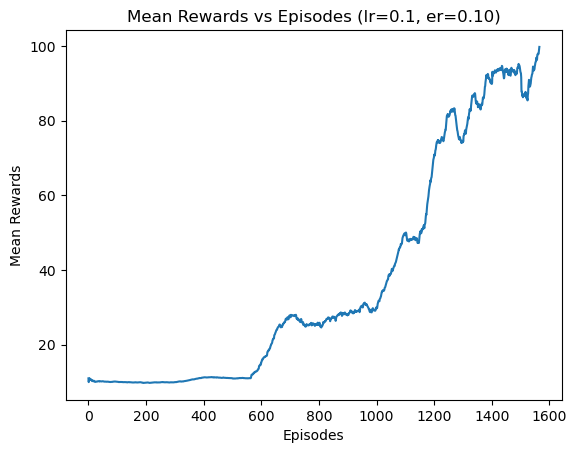

In [5]:
# Train the agent to reach a minimum of 100 average rewards
agent = QLearningAgent(env)
agent.train(min_rewards=100, plot=True)
agent.save_model()

### Correctness of Implementation
Print the values of the state and chosen action in Jupyter notebook.

In [6]:
state, action = agent.show_action()
print(f"Returned Observations: {state}")
print(f"Returned Chosen Action: {action}")

Returned Observations: [ 0.00545491 -0.01138606 -0.00593014  0.03735114]
Returned Chosen Action: 1


## 1.2 Hyperparameter Exploration and Tuning

#### Vary Learning Rate

Now, we investigate the effect of differing initial learning rates on the number of episodes needed to reach an average reward of 200. We look at learning rate at 0.05, 0.1, 0.15, 0.2, whilst keeping the initial exploration rate at 0.1.

Episode: 0 Rewards: 12.0  Epsilon: 0.10  Mean Rewards 12.0
Episode: 100 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 11.3
Episode: 200 Rewards: 15.0  Epsilon: 0.10  Mean Rewards 11.3
Episode: 300 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 11.1
Episode: 400 Rewards: 12.0  Epsilon: 0.10  Mean Rewards 11.5
Episode: 500 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 11.7
Episode: 600 Rewards: 13.0  Epsilon: 0.10  Mean Rewards 11.9
Episode: 700 Rewards: 13.0  Epsilon: 0.10  Mean Rewards 11.8
Episode: 800 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 11.4
Episode: 900 Rewards: 13.0  Epsilon: 0.10  Mean Rewards 12.3
Episode: 1000 Rewards: 19.0  Epsilon: 0.10  Mean Rewards 21.8
Episode: 1100 Rewards: 15.0  Epsilon: 0.10  Mean Rewards 21.3
Episode: 1200 Rewards: 32.0  Epsilon: 0.10  Mean Rewards 29.4
Episode: 1300 Rewards: 22.0  Epsilon: 0.10  Mean Rewards 29.2
Episode: 1400 Rewards: 54.0  Epsilon: 0.10  Mean Rewards 31.8
Episode: 1500 Rewards: 27.0  Epsilon: 0.10  Mean Rewards 29.6
Episode: 1600 Reward

Episode: 7800 Rewards: 153.0  Epsilon: 0.10  Mean Rewards 175.2
Episode: 7900 Rewards: 323.0  Epsilon: 0.10  Mean Rewards 175.8
Episode: 8000 Rewards: 171.0  Epsilon: 0.10  Mean Rewards 146.9
Episode: 8100 Rewards: 179.0  Epsilon: 0.10  Mean Rewards 149.2
Episode: 8200 Rewards: 279.0  Epsilon: 0.10  Mean Rewards 150.1
Episode: 8300 Rewards: 137.0  Epsilon: 0.10  Mean Rewards 175.3
Episode: 8400 Rewards: 164.0  Epsilon: 0.10  Mean Rewards 159.4
Episode: 8500 Rewards: 127.0  Epsilon: 0.10  Mean Rewards 152.6
Episode: 8600 Rewards: 57.0  Epsilon: 0.10  Mean Rewards 165.2
Episode: 8700 Rewards: 202.0  Epsilon: 0.10  Mean Rewards 163.4
Episode: 8800 Rewards: 283.0  Epsilon: 0.10  Mean Rewards 143.9
Episode: 8900 Rewards: 194.0  Epsilon: 0.10  Mean Rewards 175.7
Episode: 9000 Rewards: 175.0  Epsilon: 0.10  Mean Rewards 149.2
Episode: 9100 Rewards: 119.0  Epsilon: 0.10  Mean Rewards 158.3
Episode: 9200 Rewards: 138.0  Epsilon: 0.10  Mean Rewards 156.5
Episode: 9300 Rewards: 184.0  Epsilon: 0.

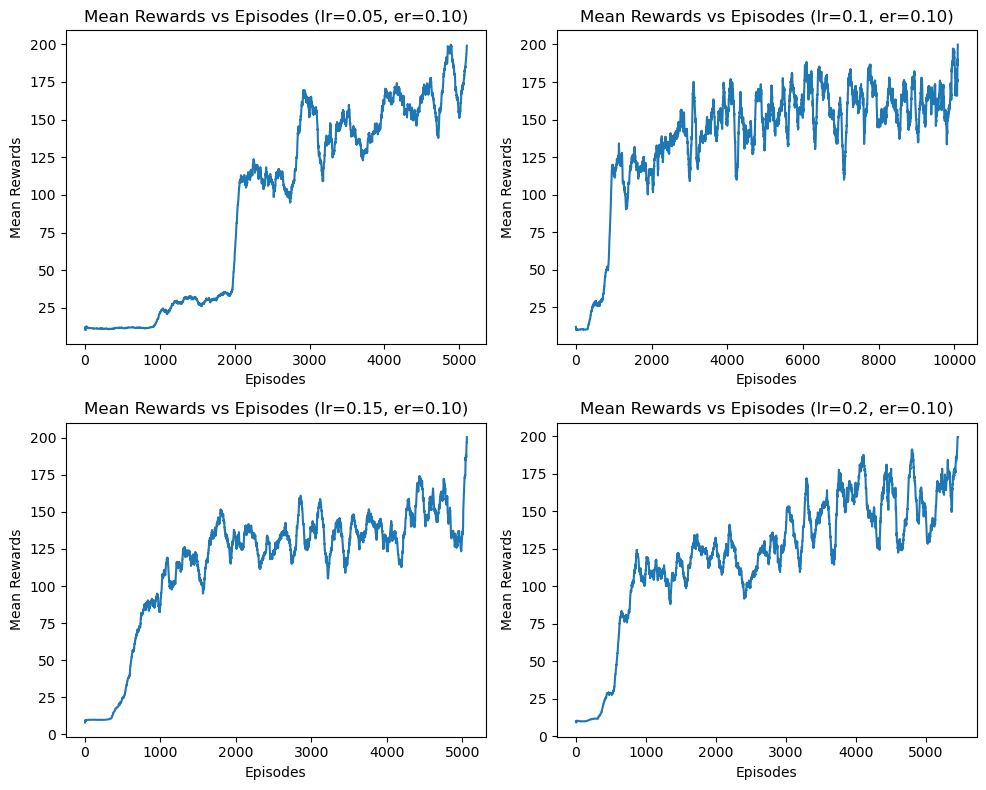

In [7]:
# Define learning rates
learning_rates = [0.05, 0.1, 0.15, 0.2]

agent = QLearningAgent(env) # Create a new agent

plt.figure(figsize=(10, 8)) # Create a figure to plot the rewards

i = 0
# Train the agent with different learning rates
for alpha in learning_rates:
    plt.subplot(2,2,i+1)
    agent.alpha = alpha # set learning rate
    agent.epsilon = 0.1 # reset epsilon
    agent.q = np.zeros((len(agent.pos_space)+1, len(agent.vel_space)+1, len(agent.ang_space)+1, len(agent.ang_vel_space)+1, agent.env.action_space.n)) # reset Q table
    
    agent.train(min_rewards=200, plot=True)
    # agent.save_model(f'cartpoleQLAgent_lr{alpha}.pkl')
    i += 1

plt.tight_layout()

#### Vary Initial Exploration Rate

Now, we investigate the effect of differing initial exploration rate on the number of episodes needed to reach an average reward of 200.

We look at initial exploration rate at 0.1, 0.2, 0.3, 0.4 while keeping the initial learning rate of 0.1.

Episode: 0 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 100 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 10.0
Episode: 200 Rewards: 10.0  Epsilon: 0.10  Mean Rewards 9.8
Episode: 300 Rewards: 17.0  Epsilon: 0.10  Mean Rewards 11.8
Episode: 400 Rewards: 22.0  Epsilon: 0.10  Mean Rewards 22.0
Episode: 500 Rewards: 20.0  Epsilon: 0.10  Mean Rewards 29.1
Episode: 600 Rewards: 8.0  Epsilon: 0.10  Mean Rewards 26.3
Episode: 700 Rewards: 32.0  Epsilon: 0.10  Mean Rewards 36.0
Episode: 800 Rewards: 43.0  Epsilon: 0.10  Mean Rewards 43.4
Episode: 900 Rewards: 45.0  Epsilon: 0.10  Mean Rewards 52.6
Episode: 1000 Rewards: 30.0  Epsilon: 0.10  Mean Rewards 57.5
Episode: 1100 Rewards: 107.0  Epsilon: 0.10  Mean Rewards 71.4
Episode: 1200 Rewards: 144.0  Epsilon: 0.10  Mean Rewards 95.4
Episode: 1300 Rewards: 138.0  Epsilon: 0.10  Mean Rewards 110.8
Episode: 1400 Rewards: 96.0  Epsilon: 0.10  Mean Rewards 112.8
Episode: 1500 Rewards: 140.0  Epsilon: 0.10  Mean Rewards 113.4
Episode: 1600 R

Episode: 3900 Rewards: 160.0  Epsilon: 0.16  Mean Rewards 163.7
Episode: 4000 Rewards: 158.0  Epsilon: 0.16  Mean Rewards 149.8
Episode: 4100 Rewards: 25.0  Epsilon: 0.16  Mean Rewards 151.1
Episode: 4200 Rewards: 180.0  Epsilon: 0.16  Mean Rewards 153.3
Episode: 4300 Rewards: 179.0  Epsilon: 0.16  Mean Rewards 186.5
Episode: 4400 Rewards: 104.0  Epsilon: 0.16  Mean Rewards 167.6
Episode: 4500 Rewards: 158.0  Epsilon: 0.15  Mean Rewards 159.3
Episode: 4600 Rewards: 219.0  Epsilon: 0.15  Mean Rewards 196.9
Episode: 4700 Rewards: 136.0  Epsilon: 0.15  Mean Rewards 117.1
Episode: 4800 Rewards: 175.0  Epsilon: 0.15  Mean Rewards 147.1
Episode: 0 Rewards: 16.0  Epsilon: 0.30  Mean Rewards 16.0
Episode: 100 Rewards: 14.0  Epsilon: 0.30  Mean Rewards 18.2
Episode: 200 Rewards: 36.0  Epsilon: 0.30  Mean Rewards 17.8
Episode: 300 Rewards: 32.0  Epsilon: 0.30  Mean Rewards 43.3
Episode: 400 Rewards: 15.0  Epsilon: 0.30  Mean Rewards 53.8
Episode: 500 Rewards: 93.0  Epsilon: 0.29  Mean Rewards 57

Episode: 3700 Rewards: 15.0  Epsilon: 0.36  Mean Rewards 104.4
Episode: 3800 Rewards: 106.0  Epsilon: 0.36  Mean Rewards 105.6
Episode: 3900 Rewards: 53.0  Epsilon: 0.36  Mean Rewards 117.0
Episode: 4000 Rewards: 160.0  Epsilon: 0.36  Mean Rewards 121.4
Episode: 4100 Rewards: 64.0  Epsilon: 0.36  Mean Rewards 117.8
Episode: 4200 Rewards: 90.0  Epsilon: 0.36  Mean Rewards 102.2
Episode: 4300 Rewards: 264.0  Epsilon: 0.36  Mean Rewards 120.9
Episode: 4400 Rewards: 97.0  Epsilon: 0.36  Mean Rewards 119.7
Episode: 4500 Rewards: 16.0  Epsilon: 0.35  Mean Rewards 77.0
Episode: 4600 Rewards: 131.0  Epsilon: 0.35  Mean Rewards 87.5
Episode: 4700 Rewards: 267.0  Epsilon: 0.35  Mean Rewards 120.0
Episode: 4800 Rewards: 11.0  Epsilon: 0.35  Mean Rewards 121.9
Episode: 4900 Rewards: 17.0  Epsilon: 0.35  Mean Rewards 106.9
Episode: 5000 Rewards: 11.0  Epsilon: 0.35  Mean Rewards 99.0
Episode: 5100 Rewards: 156.0  Epsilon: 0.35  Mean Rewards 120.4
Episode: 5200 Rewards: 44.0  Epsilon: 0.35  Mean Rew

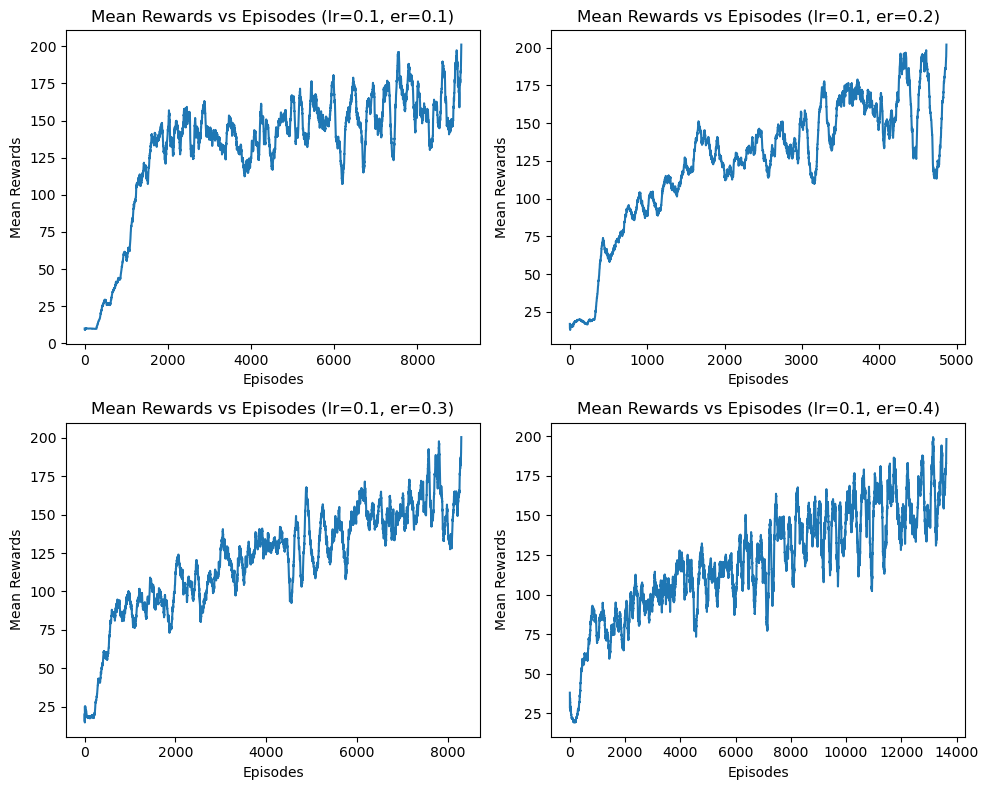

In [8]:
# Define exploration rates
exploration_rates = [0.1, 0.2, 0.3, 0.4]

agent = QLearningAgent(env) # Create a new agent

plt.figure(figsize=(10, 8)) # Create a figure to plot the rewards

i = 0
# Train the agent with different exploration rates
for epsilon in exploration_rates:
    plt.subplot(2,2,i+1)
    agent.alpha = 0.1 # reset learning rate
    agent.epsilon = epsilon # set exploration rate
    agent.q = np.zeros((len(agent.pos_space)+1, len(agent.vel_space)+1, len(agent.ang_space)+1, len(agent.ang_vel_space)+1, agent.env.action_space.n)) # reset Q table
    
    agent.train(min_rewards=200, plot=True)
    plt.title(f'Mean Rewards vs Episodes (lr={0.1}, er={epsilon})')
    # agent.save_model(f'cartpoleQLAgent_epsilon{epsilon}.pkl')
    i += 1

plt.tight_layout()

#### Deciding the Choice of Best Hyper-Parameters

After preliminary investigation on the hyper-parameters, we decide on a learning rate of 0.2 and initial exploration rate of 0.2 for our Agent.

Now we will train the Agent using the chosen hyper-parameters.

Episode: 0 Rewards: 59.0  Epsilon: 0.20  Mean Rewards 59.0
Episode: 100 Rewards: 39.0  Epsilon: 0.20  Mean Rewards 18.7
Episode: 200 Rewards: 136.0  Epsilon: 0.20  Mean Rewards 32.3
Episode: 300 Rewards: 12.0  Epsilon: 0.20  Mean Rewards 59.4
Episode: 400 Rewards: 97.0  Epsilon: 0.20  Mean Rewards 62.3
Episode: 500 Rewards: 125.0  Epsilon: 0.19  Mean Rewards 82.3
Episode: 600 Rewards: 151.0  Epsilon: 0.19  Mean Rewards 68.3
Episode: 700 Rewards: 69.0  Epsilon: 0.19  Mean Rewards 83.5
Episode: 800 Rewards: 41.0  Epsilon: 0.19  Mean Rewards 80.5
Episode: 900 Rewards: 133.0  Epsilon: 0.19  Mean Rewards 83.9
Episode: 1000 Rewards: 109.0  Epsilon: 0.19  Mean Rewards 108.9
Episode: 1100 Rewards: 73.0  Epsilon: 0.19  Mean Rewards 103.2
Episode: 1200 Rewards: 20.0  Epsilon: 0.19  Mean Rewards 102.2
Episode: 1300 Rewards: 138.0  Epsilon: 0.19  Mean Rewards 118.3
Episode: 1400 Rewards: 47.0  Epsilon: 0.19  Mean Rewards 92.7
Episode: 1500 Rewards: 154.0  Epsilon: 0.18  Mean Rewards 110.5
Episode:

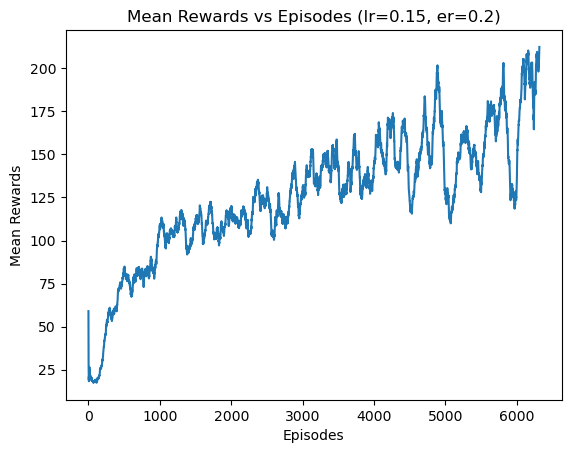

In [12]:
# Train the agent with lr = 0.15 and er = 0.2
env = gym.make('CartPole-v1')
agent = QLearningAgent(env)
agent.alpha = 0.15
agent.epsilon = 0.2
agent.train(min_rewards=210, plot=True)
plt.title(f'Mean Rewards vs Episodes (lr={agent.alpha}, er={0.2})')
agent.save_model('cartpoleQLAgent.pkl')


# Task 2: Testing of the RL Agent


## 2.1 Testing Q-learning Agent

We first load the pickle file containing the parameters for the Q-learning agent we have trained above.

Episode: 1 Rewards: 333.0
Episode: 2 Rewards: 249.0
Episode: 3 Rewards: 176.0
Episode: 4 Rewards: 216.0
Episode: 5 Rewards: 312.0
Episode: 6 Rewards: 167.0
Episode: 7 Rewards: 181.0
Episode: 8 Rewards: 174.0
Episode: 9 Rewards: 155.0
Episode: 10 Rewards: 424.0
Episode: 11 Rewards: 335.0
Episode: 12 Rewards: 238.0
Episode: 13 Rewards: 225.0
Episode: 14 Rewards: 156.0
Episode: 15 Rewards: 365.0
Episode: 16 Rewards: 289.0
Episode: 17 Rewards: 197.0
Episode: 18 Rewards: 247.0
Episode: 19 Rewards: 182.0
Episode: 20 Rewards: 262.0
Episode: 21 Rewards: 178.0
Episode: 22 Rewards: 196.0
Episode: 23 Rewards: 234.0
Episode: 24 Rewards: 221.0
Episode: 25 Rewards: 330.0
Episode: 26 Rewards: 532.0
Episode: 27 Rewards: 319.0
Episode: 28 Rewards: 187.0
Episode: 29 Rewards: 151.0
Episode: 30 Rewards: 391.0
Episode: 31 Rewards: 372.0
Episode: 32 Rewards: 170.0
Episode: 33 Rewards: 204.0
Episode: 34 Rewards: 225.0
Episode: 35 Rewards: 172.0
Episode: 36 Rewards: 214.0
Episode: 37 Rewards: 314.0
Episode: 3

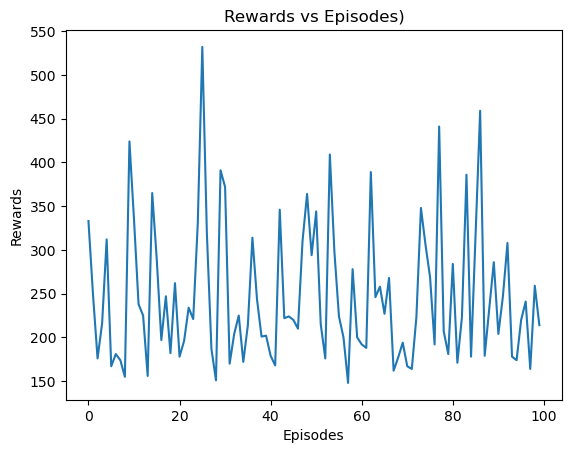

In [13]:
# Testing the agent
env = gym.make('CartPole-v1')
agent = QLearningAgent(env)
agent.load_model('cartpoleQLAgent.pkl')
episode_results = agent.test(num_episodes=100, plot=True)

In [14]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 246.94
Is my agent good enough? True


# Task 3: Render


In [15]:
#!pip install moviepy
#!pip install pygame
#!pip install gym[classic_control]
from IPython.display import Video

env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordVideo(env, './video/QL')
agent = QLearningAgent(env)
agent.load_model('cartpoleQLAgent.pkl')
agent.run_one_episode(is_training=False)
env.close()
#show_video()
Video("C:/Users/russe/Downloads/video/QL/rl-video-episode-0.mp4", embed=True)


MoviePy - Building video C:\Users\russe\Downloads\video\QL\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\russe\Downloads\video\QL\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\russe\Downloads\video\QL\rl-video-episode-0.mp4
